## Data Science Assessment for Andani

In [2115]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
import glob
import os


In [2116]:
csv_files = glob.glob('oulad_data/*.csv')
dataframes = {os.path.basename(file): pd.read_csv(file) for file in csv_files}

In [2117]:
dataframes.keys()

dict_keys(['assessments.csv', 'courses.csv', 'studentAssessment.csv', 'studentInfo.csv', 'studentRegistration.csv', 'studentVle.csv', 'vle.csv'])

In [2118]:
for name in list(dataframes.keys()):
    old_name = name
    new_name = name.removesuffix(".csv")
    dataframes.update( {new_name: dataframes.pop(old_name)})

In [2119]:
dataframes.keys()

dict_keys(['assessments', 'courses', 'studentAssessment', 'studentInfo', 'studentRegistration', 'studentVle', 'vle'])

In [2120]:
dataframes['assessments'].head(10)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1,TMA,30,20
1,AAA,2013J,2,TMA,75,20
2,AAA,2013J,3,TMA,120,20
3,AAA,2013J,4,Exam,230,100
4,AAA,2014B,5,TMA,30,20
5,AAA,2014B,6,CMA,75,30
6,AAA,2014B,7,TMA,120,20
7,AAA,2014B,8,Exam,230,100
8,BBB,2013J,9,CMA,30,30
9,BBB,2013J,10,CMA,75,30


In [2121]:
dataframes['courses'].head()

,code_module,code_presentation,length
0,AAA,2013J,240
1,AAA,2014B,240
2,BBB,2013J,240
3,BBB,2014B,240
4,CCC,2013J,240


In [2122]:
dataframes['studentAssessment'].head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1,9,26,0,29
1,1,10,28,0,55
2,1,12,29,0,76
3,1,16,27,0,24
4,1,19,24,0,19


In [2123]:
#def     total_weighted_score(score)

In [2124]:
dataframes['studentInfo'].head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,BBB,2014B,1,M,Wales,A Level or Equivalent,20-30%,55<=,2,90,N,Fail
1,EEE,2014B,2,F,North Region,A Level or Equivalent,40-50%,0-35,1,150,N,Pass
2,DDD,2013J,2,M,South East Region,Post Graduate Qualification,20-30%,55<=,0,90,N,Fail
3,CCC,2014B,3,F,South East Region,HE Qualification,90-100%,0-35,1,120,N,Fail
4,BBB,2014B,4,M,South Region,A Level or Equivalent,70-80%,35-55,1,60,N,Distinction


In [2125]:
dataframes['studentInfo'].id_student.nunique()

1000

In [2126]:
dataframes['studentRegistration'].head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,BBB,2014B,1,-51,NaN
1,EEE,2014B,2,-40,NaN
2,DDD,2013J,2,-56,NaN
3,CCC,2014B,3,-50,NaN
4,BBB,2014B,4,-39,NaN


In [2127]:
dataframes['studentVle'].head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,BBB,2014B,1,68,57,1
1,BBB,2014B,1,63,73,3
2,BBB,2014B,1,67,176,3
3,BBB,2014B,1,76,53,9
4,BBB,2014B,1,79,193,4


In [2128]:
dataframes['studentVle'].id_student.nunique()

1000

In [2135]:
dataframes['vle'].head(20)

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,1,AAA,2013J,quiz,4,12
1,2,AAA,2013J,subpage,25,32
2,3,AAA,2013J,page,4,7
3,4,AAA,2013J,glossary,7,11
4,5,AAA,2013J,oucontent,20,21
5,6,AAA,2013J,glossary,27,34
6,7,AAA,2013J,resource,26,30
7,8,AAA,2013J,forum,3,6
8,9,AAA,2013J,quiz,1,5
9,10,AAA,2013J,subpage,1,9


In [2130]:
df_studentVle = dataframes['studentVle'].groupby(['code_module','code_presentation','id_student'],sort=False)['sum_click'].sum().reset_index()

In [2131]:
df_studentVle

,code_module,code_presentation,id_student,sum_click
0,BBB,2014B,1,375
1,EEE,2014B,2,201
2,DDD,2013J,2,52
3,CCC,2014B,3,245
4,BBB,2014B,4,780
...,...,...,...,...
1502,EEE,2013J,998,446
1503,BBB,2014B,998,461
1504,AAA,2014B,999,155
1505,EEE,2014B,999,244


In [2132]:
print(df_studentVle.id_student.nunique())
dataframes['studentVle'].id_site.nunique()

1000


200

In [2133]:
df_studentVle[df_studentVle.id_student==100]

,code_module,code_presentation,id_student,sum_click
143,BBB,2014B,100,597
144,DDD,2014B,100,241


In [2134]:
vle_df = df_studentVle.merge(dataframes['vle'], on = ['id_site','code_module','code_presentation'],how = 'left')

KeyError: 'id_site'

In [ ]:
vle_df

,code_module,code_presentation,id_student,id_site,sum_click,activity_type,week_from,week_to
0,BBB,2014B,1,68,13,url,23,24
1,BBB,2014B,1,63,17,url,26,31
2,BBB,2014B,1,67,36,forum,8,14
3,BBB,2014B,1,76,34,oucontent,4,11
4,BBB,2014B,1,79,11,page,26,28
...,...,...,...,...,...,...,...,...
27092,AAA,2014B,1000,26,21,glossary,27,32
27093,AAA,2014B,1000,38,19,page,26,35
27094,AAA,2014B,1000,28,32,url,22,31
27095,AAA,2014B,1000,24,16,url,26,27


In [ ]:
for name in list(dataframes.keys()):
    print(f'number of rows in {name}: {len(dataframes[name])}')

number of rows in assessments: 40
number of rows in courses: 10
number of rows in studentAssessment: 5392
number of rows in studentInfo: 1507
number of rows in studentRegistration: 1507
number of rows in studentVle: 114130
number of rows in vle: 200


In [ ]:
df_1 = dataframes['assessments'].merge(dataframes['courses'],on = ['code_module','code_presentation'] ,how = 'left')
df_1.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,length
0,AAA,2013J,1,TMA,30,20,240
1,AAA,2013J,2,TMA,75,20,240
2,AAA,2013J,3,TMA,120,20,240
3,AAA,2013J,4,Exam,230,100,240
4,AAA,2014B,5,TMA,30,20,240


In [ ]:
df_1.shape

(40, 7)

In [ ]:
df_1 = df_1.merge(dataframes['studentAssessment'],on = ['id_assessment'] ,how = 'left')
df_1.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,length,id_student,date_submitted,is_banked,score
0,AAA,2013J,1,TMA,30,20,240,9,26,0,29
1,AAA,2013J,1,TMA,30,20,240,10,28,0,55
2,AAA,2013J,1,TMA,30,20,240,12,29,0,76
3,AAA,2013J,1,TMA,30,20,240,16,27,0,24
4,AAA,2013J,1,TMA,30,20,240,19,24,0,19


In [ ]:
#df_1[df_1.id_student == 1]
np.max(df_1[df_1.assessment_type == 'Exam']['score'])
df_1['weighted_score'] = (df_1['score']/100) * df_1['weight']
df_1.head(10)

,code_module,code_presentation,id_assessment,assessment_type,date,weight,length,id_student,date_submitted,is_banked,score,weighted_score
0,AAA,2013J,1,TMA,30,20,240,9,26,0,29,5.8
1,AAA,2013J,1,TMA,30,20,240,10,28,0,55,11.0
2,AAA,2013J,1,TMA,30,20,240,12,29,0,76,15.2
3,AAA,2013J,1,TMA,30,20,240,16,27,0,24,4.8
4,AAA,2013J,1,TMA,30,20,240,19,24,0,19,3.8
5,AAA,2013J,1,TMA,30,20,240,24,29,0,29,5.8
6,AAA,2013J,1,TMA,30,20,240,29,29,0,58,11.6
7,AAA,2013J,1,TMA,30,20,240,30,27,0,73,14.6
8,AAA,2013J,1,TMA,30,20,240,43,25,0,83,16.6
9,AAA,2013J,1,TMA,30,20,240,49,30,0,84,16.8


In [ ]:
cols = ['code_module', 'code_presentation', 'assessment_type','length','id_student','is_banked']

df = df_1.groupby(cols,as_index=False)[['weighted_score','weight']].sum()

In [ ]:
df[df['id_student']==1]

,code_module,code_presentation,assessment_type,length,id_student,is_banked,weighted_score,weight
1045,BBB,2014B,CMA,240,1,0,12.6,60
1208,BBB,2014B,Exam,240,1,0,18.0,100
1362,BBB,2014B,TMA,240,1,0,10.2,20


In [ ]:
cols = ['code_module', 'code_presentation','length','id_student','is_banked']
df = df_1.groupby(cols,as_index=False)[['weighted_score','weight']].sum()

In [ ]:
df

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight
0,AAA,2013J,240,9,0,63.4,160
1,AAA,2013J,240,10,0,92.8,160
2,AAA,2013J,240,12,0,121.2,160
3,AAA,2013J,240,16,0,77.6,160
4,AAA,2013J,240,19,0,33.4,160
...,...,...,...,...,...,...,...
1424,EEE,2014B,240,955,0,40.8,160
1425,EEE,2014B,240,980,0,145.4,160
1426,EEE,2014B,240,985,0,141.0,160
1427,EEE,2014B,240,986,0,24.8,160


In [ ]:
df.shape

(1429, 7)

In [ ]:
df_1 = df.merge(dataframes['studentInfo'],on = ['code_module','code_presentation','id_student'] ,how = 'left')
df_1.head()

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,240,9,0,63.4,160,F,South East Region,Post Graduate Qualification,80-90%,55<=,1,30,N,Fail
1,AAA,2013J,240,10,0,92.8,160,F,North Western Region,HE Qualification,40-50%,0-35,0,90,N,Pass
2,AAA,2013J,240,12,0,121.2,160,M,South Region,Post Graduate Qualification,30-40%,55<=,1,90,N,Pass
3,AAA,2013J,240,16,0,77.6,160,F,Wales,HE Qualification,0-10%,0-35,0,90,N,Fail
4,AAA,2013J,240,19,0,33.4,160,F,East Midlands Region,No Formal quals,90-100%,55<=,0,120,N,Fail


In [ ]:
df_1.shape

(1429, 16)

In [ ]:
df_1 = df_1.merge(dataframes['studentRegistration'],on = ['code_module','code_presentation','id_student'] ,how = 'left')
df_1.head()

,code_module,code_presentation,length,id_student,is_banked,weighted_score,weight,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration
0,AAA,2013J,240,9,0,63.4,160,F,South East Region,Post Graduate Qualification,80-90%,55<=,1,30,N,Fail,-15,NaN
1,AAA,2013J,240,10,0,92.8,160,F,North Western Region,HE Qualification,40-50%,0-35,0,90,N,Pass,-25,NaN
2,AAA,2013J,240,12,0,121.2,160,M,South Region,Post Graduate Qualification,30-40%,55<=,1,90,N,Pass,-38,NaN
3,AAA,2013J,240,16,0,77.6,160,F,Wales,HE Qualification,0-10%,0-35,0,90,N,Fail,-41,NaN
4,AAA,2013J,240,19,0,33.4,160,F,East Midlands Region,No Formal quals,90-100%,55<=,0,120,N,Fail,-27,NaN


In [ ]:
df_1.shape

(1429, 18)

In [ ]:
df_studentVle.head()

,code_module,code_presentation,id_student,id_site,sum_click
0,BBB,2014B,1,68,13
1,BBB,2014B,1,63,17
2,BBB,2014B,1,67,36
3,BBB,2014B,1,76,34
4,BBB,2014B,1,79,11


In [ ]:
cols = ['code_module', 'code_presentation','length','id_student','is_banked']
df = df_1.groupby(cols,as_index=False)[['weighted_score','weight']].sum()

In [ ]:
# df_1 = df_1.merge(df_studentVle,on = ['code_module','code_presentation','id_student'] ,how = 'left')
# df_1.head(15)

In [ ]:
# df_1.shape

In [ ]:
# df_1 = df_1.merge(dataframes['vle'], on = ['id_site','code_module','code_presentation'], how='left')
# df_1.head(10)

In [ ]:
df_1.shape

(1429, 18)

In [ ]:
df_1.columns

Index(['code_module', 'code_presentation', 'length', 'id_student', 'is_banked',
       'weighted_score', 'weight', 'gender', 'region', 'highest_education',
       'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits',
       'disability', 'final_result', 'date_registration',
       'date_unregistration'],
      dtype='object')

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           1429 non-null   object 
 1   code_presentation     1429 non-null   object 
 2   length                1429 non-null   int64  
 3   id_student            1429 non-null   int64  
 4   is_banked             1429 non-null   int64  
 5   weighted_score        1429 non-null   float64
 6   weight                1429 non-null   int64  
 7   gender                1429 non-null   object 
 8   region                1429 non-null   object 
 9   highest_education     1429 non-null   object 
 10  imd_band              1429 non-null   object 
 11  age_band              1429 non-null   object 
 12  num_of_prev_attempts  1429 non-null   int64  
 13  studied_credits       1429 non-null   int64  
 14  disability            1429 non-null   object 
 15  final_result         

In [ ]:
df_1.describe()

,length,id_student,is_banked,weighted_score,weight,num_of_prev_attempts,studied_credits,date_registration,date_unregistration
count,1429.0,1429.000000,1429.0,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,128.000000
mean,240.0,503.380686,0.0,94.559132,160.125962,0.997901,89.937019,-34.178446,122.968750
std,0.0,289.710863,0.0,47.220268,39.929712,0.805702,42.715054,14.600840,43.795865
min,240.0,1.000000,0.0,0.000000,20.000000,0.000000,30.000000,-59.000000,31.000000
25%,240.0,252.000000,0.0,50.600000,160.000000,0.000000,60.000000,-47.000000,88.750000
50%,240.0,504.000000,0.0,113.200000,170.000000,1.000000,90.000000,-34.000000,126.500000
75%,240.0,756.000000,0.0,129.200000,180.000000,2.000000,120.000000,-21.000000,157.000000
max,240.0,1000.000000,0.0,178.300000,180.000000,2.000000,150.000000,-10.000000,198.000000


In [ ]:
#df_1.drop(['length', 'score'], axis=1, inplace=True)

In [ ]:
vle_df.describe()

,id_student,id_site,sum_click,week_from,week_to
count,27097.000000,27097.00000,27097.000000,27097.000000,27097.000000
mean,504.886777,100.13865,21.085249,15.133114,20.008377
std,289.679445,56.87700,14.848264,8.724118,8.720382
min,1.000000,1.00000,1.000000,1.000000,3.000000
25%,253.000000,52.00000,9.000000,8.000000,12.000000
50%,505.000000,98.00000,18.000000,15.000000,20.000000
75%,759.000000,149.00000,29.000000,23.000000,28.000000
max,1000.000000,200.00000,112.000000,29.000000,35.000000


In [ ]:
df_1.dtypes

code_module              object
code_presentation        object
length                    int64
id_student                int64
is_banked                 int64
weighted_score          float64
weight                    int64
gender                   object
region                   object
highest_education        object
imd_band                 object
age_band                 object
num_of_prev_attempts      int64
studied_credits           int64
disability               object
final_result             object
date_registration         int64
date_unregistration     float64
dtype: object

In [ ]:
df_categorical = df_1.select_dtypes(include=object)
len(df_categorical.columns)

9

In [ ]:
df_numerical = df_1.select_dtypes(exclude=object)
len(df_numerical.columns)

9

In [ ]:
for col in df_categorical.columns:
    unique = df_categorical[col].unique()
    unique.sort()
    print(f'- {col}: has {len(unique)} unique values \n  {unique}')

- code_module: has 5 unique values 
  ['AAA' 'BBB' 'CCC' 'DDD' 'EEE']
- code_presentation: has 2 unique values 
  ['2013J' '2014B']
- gender: has 2 unique values 
  ['F' 'M']
- region: has 11 unique values 
  ['East Anglian Region' 'East Midlands Region' 'London Region'
 'North Region' 'North Western Region' 'Scotland' 'South East Region'
 'South Region' 'South West Region' 'Wales' 'West Midlands Region']
- highest_education: has 5 unique values 
  ['A Level or Equivalent' 'HE Qualification' 'Lower Than A Level'
 'No Formal quals' 'Post Graduate Qualification']
- imd_band: has 10 unique values 
  ['0-10%' '10-20%' '20-30%' '30-40%' '40-50%' '50-60%' '60-70%' '70-80%'
 '80-90%' '90-100%']
- age_band: has 3 unique values 
  ['0-35' '35-55' '55<=']
- disability: has 2 unique values 
  ['N' 'Y']
- final_result: has 4 unique values 
  ['Distinction' 'Fail' 'Pass' 'Withdrawn']


In [ ]:
def categorize_region(region):
    if region in ['North Region', 'North Western Region', 'Scotland']:
        return 'North'
    elif region in ['East Midlands Region', 'West Midlands Region']:
        return 'Midlands'
    elif region in ['South Region', 'South West Region']:
        return 'South'
    elif region in ['South East Region', 'London Region']:
        return 'South East & London'
    elif region in ['East Anglian Region', 'Wales']:
        return 'East & Wales'
    else:
        return 'Unknown'

df_1['Area'] = df_1['region'].apply(categorize_region)
df_1[['Area','region']]

,Area,region
0,South East & London,South East Region
1,North,North Western Region
2,South,South Region
3,East & Wales,Wales
4,Midlands,East Midlands Region
...,...,...
1424,South East & London,South East Region
1425,East & Wales,East Anglian Region
1426,East & Wales,East Anglian Region
1427,Midlands,East Midlands Region


In [ ]:
def categorize_band(percentage):
    if percentage in ['0-10%', '10-20%']:
        return 'Very Low'
    elif percentage in ['20-30%', '30-40%']:
        return 'Low'
    elif percentage in ['40-50%', '50-60%']:
        return 'Medium'
    elif percentage in ['60-70%', '70-80%']:
        return 'High'
    elif percentage in ['80-90%', '90-100%']:
        return 'Very High'
    else:
        return 'Unknown'

# Apply the function
df_1['percent range'] = df_1['imd_band'].apply(categorize_band)
df_1[['imd_band','percent range']]

,imd_band,percent range
0,80-90%,Very High
1,40-50%,Medium
2,30-40%,Low
3,0-10%,Very Low
4,90-100%,Very High
...,...,...
1424,60-70%,High
1425,80-90%,Very High
1426,30-40%,Low
1427,90-100%,Very High


In [ ]:
def categorize_qualification(qual):
    if qual == 'No Formal quals':
        return 'None'
    elif qual == 'Lower Than A Level':
        return 'Lower Than A'
    elif qual == 'A Level or Equivalent':
        return 'Mid or A-level'
    elif qual == 'HE Qualification':
        return 'Higher'
    elif qual == 'Post Graduate Qualification':
        return 'Postgrad'
    else:
        return 'Unknown'

# Apply the function
df_1['Qualification'] = df_1['highest_education'].apply(categorize_qualification)

In [ ]:
df_1.drop(['region','imd_band','highest_education'], axis=1, inplace=True)

In [ ]:
df_categorical = df_1.select_dtypes(include=object)
df_numerical = df_1.select_dtypes(exclude=object)

C:\Users\dsiph\AppData\Local\Temp\ipykernel_19736\2191344882.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x =col, data = df_numerical, fill=True, ax = ax[i[0],i[1]])
C:\Users\dsiph\AppData\Local\Temp\ipykernel_19736\2191344882.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x =col, data = df_numerical, fill=True, ax = ax[i[0],i[1]])


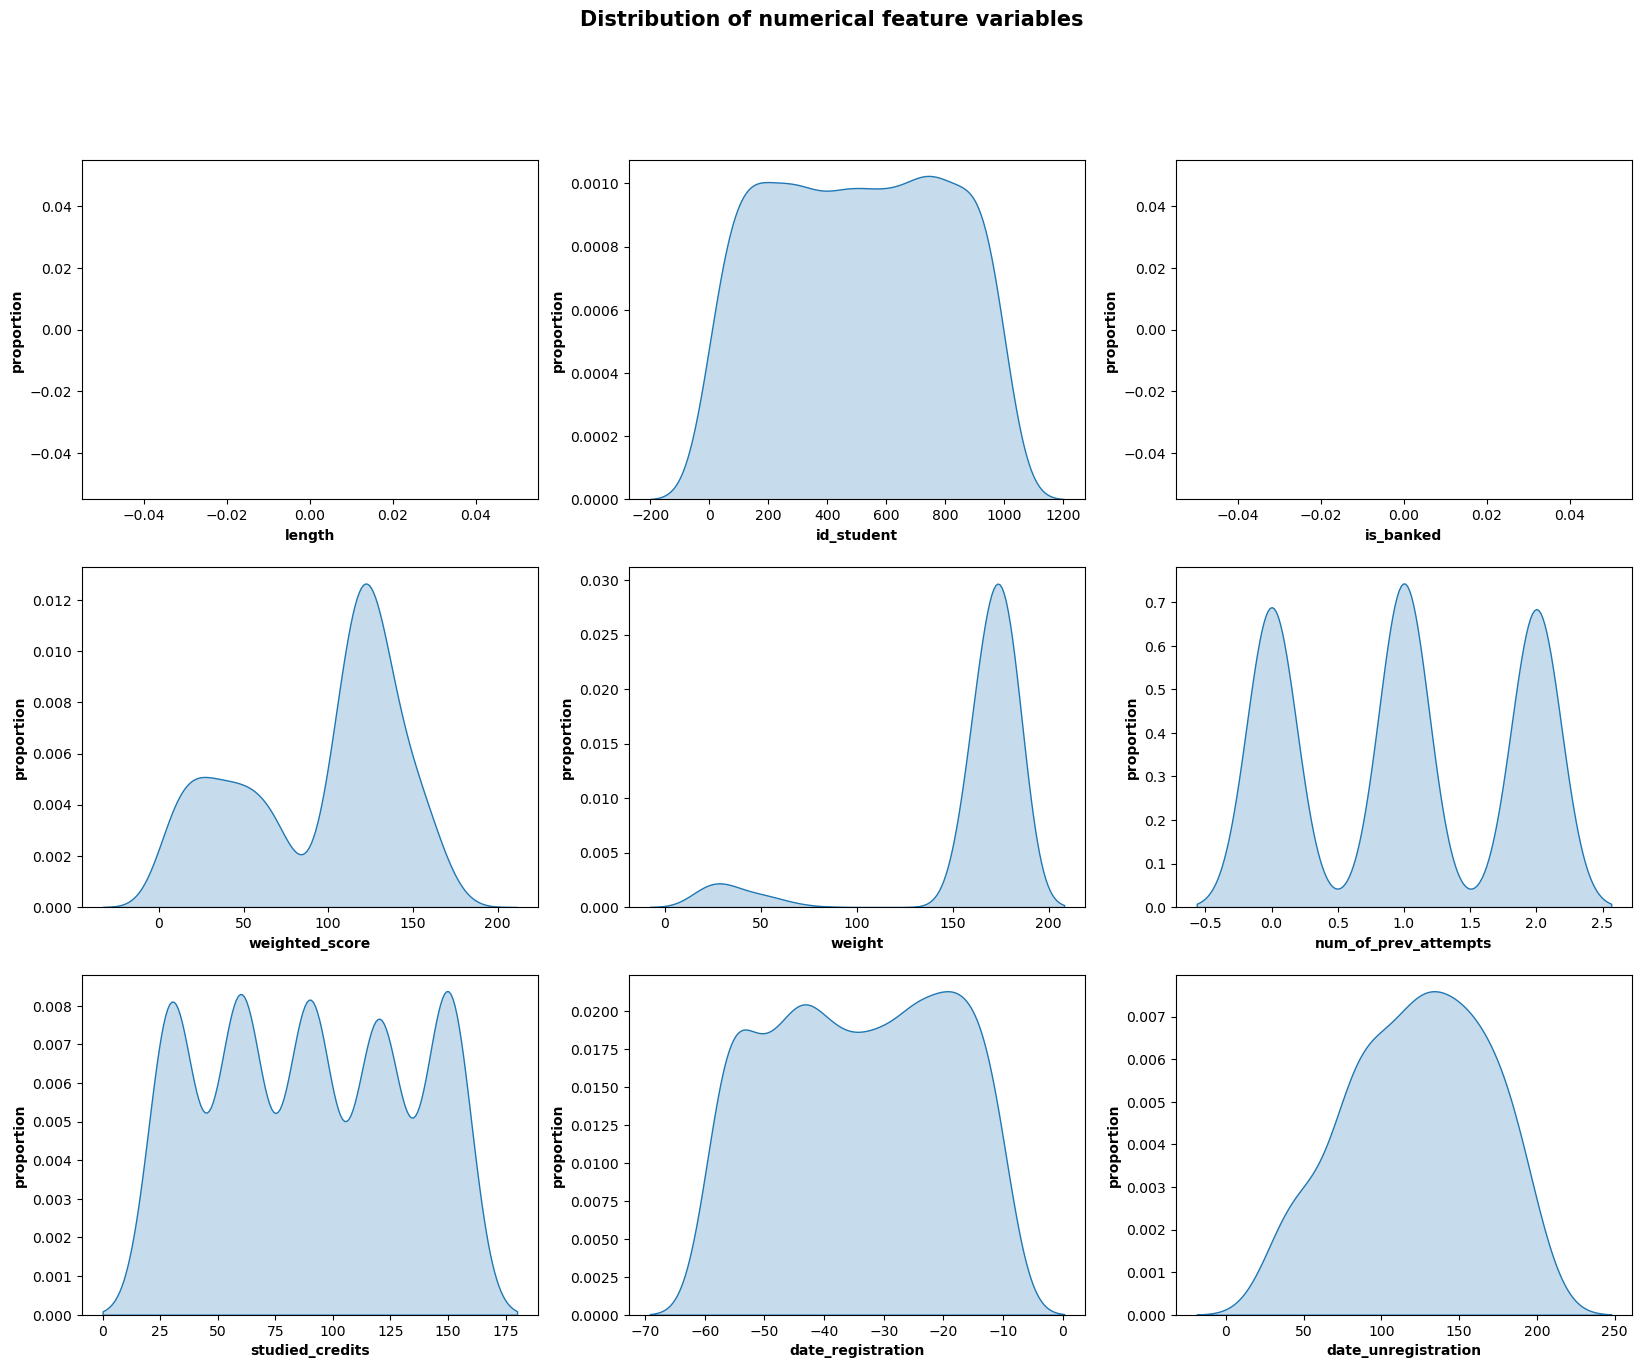

In [ ]:
features_array = np.array(df_numerical.columns, dtype='object').reshape(3,3)
fig, ax  =  plt.subplots(3,3,sharey=False,figsize=(20,15))
for i, col in np.ndenumerate(features_array):
    sns.kdeplot(x =col, data = df_numerical, fill=True, ax = ax[i[0],i[1]])
    ax[i[0],i[1]].set_xlabel(col, fontweight="bold")
    ax[i[0],i[1]].set_ylabel("proportion", fontweight="bold")
plt.suptitle("Distribution of numerical feature variables", fontweight="bold", size=(15))
plt.show()

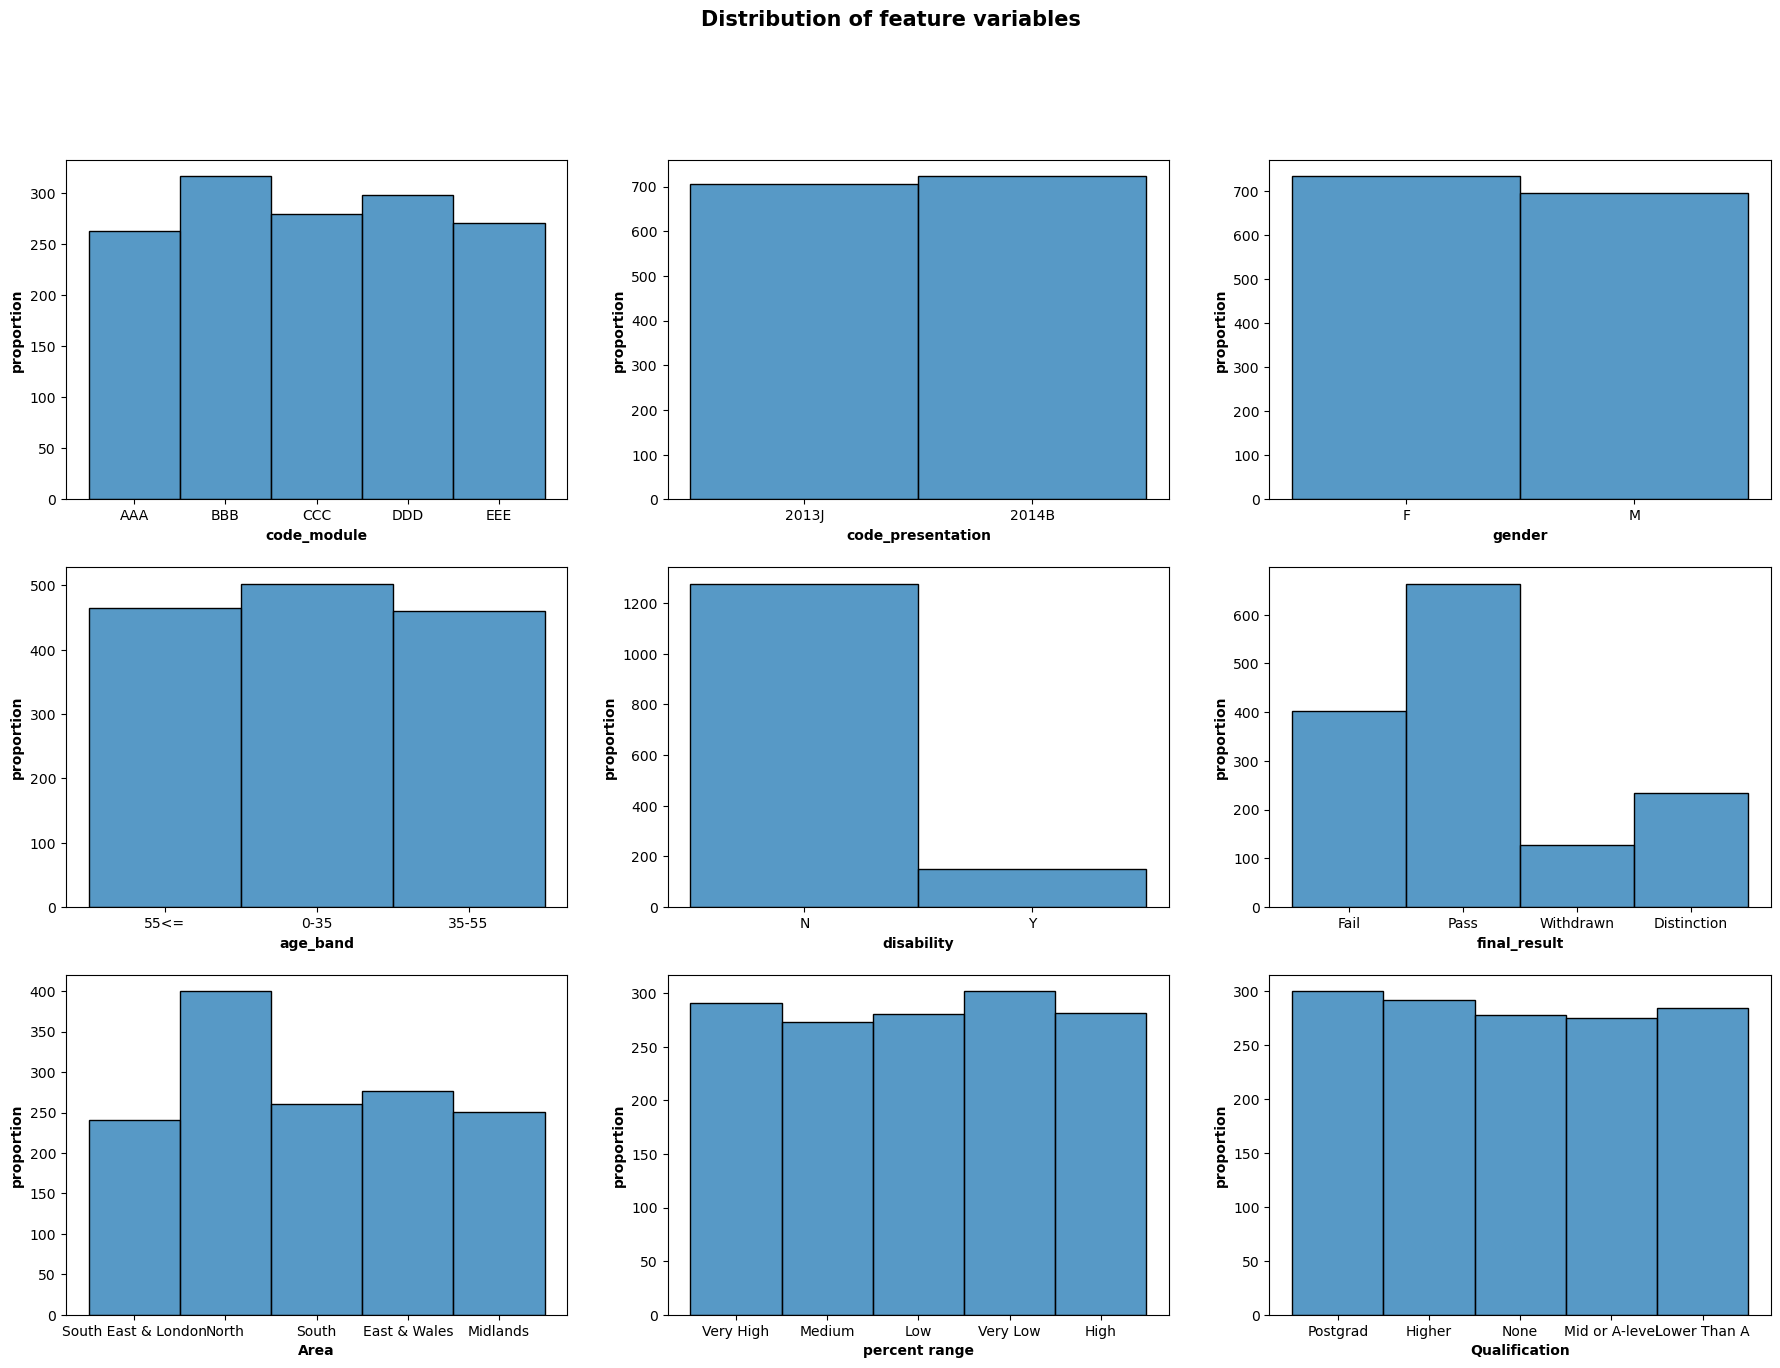

In [ ]:
features_array_cat = np.array(df_categorical.columns, dtype='object').reshape(3,3)
fig, ax  =  plt.subplots(3,3,sharey=False,figsize=(22,15))
for i, col in np.ndenumerate(features_array_cat):
    sns.histplot(x =col, data = df_categorical, fill=True, ax = ax[i[0],i[1]])
    ax[i[0],i[1]].set_xlabel(col, fontweight="bold")
    ax[i[0],i[1]].set_ylabel("proportion", fontweight="bold")
plt.suptitle("Distribution of feature variables", fontweight="bold", size=(15))
plt.show()
#v